#### create connection to SQL server database

In [ ]:
import pyodbc

server = '' 
database = '' 
username = '' 
password = '' 
cnxn = pyodbc.connect('driver={SQL Server};server='+server+';database='+database+';uid='+username+';pwd='+ password)

#shorter version of the above lines
#cnxn = pyodbc.connect('driver={SQL Server};server=;database=;uid=;pwd=')

cursor = cnxn.cursor()

#### create SQL query

In [1]:
tableName = ''
Category = ''
startDate = ''
endDate = '' # not including
query = "SELECT * FROM "+tableName+" WHERE Category = N'"+Category+"' AND TimeStamp BETWEEN '"+startDate+"' AND '"+endDate+"'"

#### create pandas DataFrame from SQL query using Connection

In [2]:
import pandas as pd

df = pd.read_sql_query(query, cnxn)

#### save DataFrame to excel for reference or other offline operations

In [3]:
df.to_excel(r"EXCEL_FILE_NAME.xlsx", sheet_name=r'data') 

#### Correct hebrew display

In [4]:
from bidi import algorithm as bidialg

df.SubCategoryName = df.SubCategoryName.map(bidialg.get_display)
df.Product = df.Product.map(bidialg.get_display)

#### import libabries for data plotting

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.ticker import FuncFormatter

#### Plot sold quantity by subcategory

In [6]:
SubCategoryQuantities = df[df.Quantity > 0].groupby(['SubCategoryName']).sum().Quantity.sort_values(ascending=False)

In [7]:
colors = ['#FF30B0', '#48FF30', '#FFF130',]
SubCategoryColors = {x: colors[i] for i, x in enumerate(SubCategoryQuantities.index)}

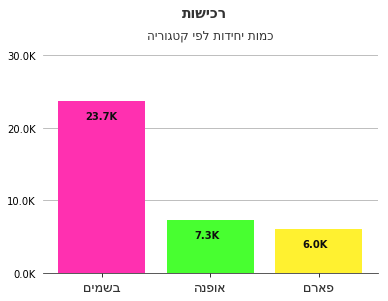

In [8]:
# create bar plot figure
plt.bar(SubCategoryQuantities.index, SubCategoryQuantities, zorder=3, color=SubCategoryColors.values())


# format axis labels usig a fucntion
def changeyaxis (x, pos):
    """the two args are the value and tick position"""
    if x >= 1e6:
        s = '{:1.1f}M'.format(x*1e-6)
    else:
        s = '{:1.1f}K'.format(x*1e-3)
    return s

yformatter = FuncFormatter(changeyaxis)
ax = plt.gca()
ax.yaxis.set_major_formatter(yformatter) 

# format axis borders
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False) 
ax.spines['left'].set_color('none')
ax.spines['bottom'].set_color('#333333')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('none')

# change y axis intervals
ax.yaxis.set_ticks(np.arange(0, max(SubCategoryQuantities)+10000, 10000))


# add title
ax.set_title(bidialg.get_display(u'כמות יחידות לפי קטגוריה'), fontsize=12, color='#333333', y=1.05) 
plt.suptitle(bidialg.get_display(u'רכישות'), fontsize=14, fontweight='semibold', color='#333333', y=1.05) 

# format ticks
plt.xticks(fontfamily = 'arial', fontsize = 14, color = '#333333')


for i, v in enumerate(SubCategoryQuantities):
    plt.annotate("{}".format(changeyaxis(v,0)), xy=(i, v), xytext=(i-.15, v - 2500), color='#0f0f0f', fontweight='semibold')

# add grid
ax.grid(axis='y', zorder=0)


# save plot to png file
plt.savefig('quantity_by_subCategory.png', transparent=True, dpi=600, bbox_inches='tight')

plt.show()



#### Plot refunded quantities by subcategory

In [9]:
SubCategoryQuantitiesRefund = df[df.Quantity < 0].groupby(['SubCategoryName']).sum().Quantity.sort_values()
SubCategoryRefundPercentage = -(SubCategoryQuantitiesRefund/SubCategoryQuantities)*100

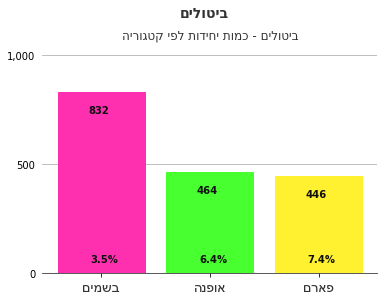

In [10]:
fig, ax = plt.subplots()
ax.bar(SubCategoryQuantitiesRefund.index, -SubCategoryQuantitiesRefund, zorder=3)

# set bar colors based on category
for i in SubCategoryQuantitiesRefund.index:
    for k, v in SubCategoryColors.items():
        if i == k:
            ax.get_children()[SubCategoryQuantitiesRefund.index.to_list().index(i)].set_color(v) 


# format axis borders
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False) 
ax.spines['left'].set_color('none')
ax.spines['bottom'].set_color('#333333')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('none')

# change y axis intervals
ax.yaxis.set_ticks(np.arange(0, -min(SubCategoryQuantitiesRefund)+500, 500))

# add title
ax.set_title(bidialg.get_display(u'ביטולים - כמות יחידות לפי קטגוריה'), fontsize=12, color='#333333', y=1.05) 
fig.suptitle(bidialg.get_display(u'ביטולים'), fontsize=14, fontweight='semibold', color='#333333', y=1.05) 

# format x labels
labels = ax.get_xticklabels()
plt.setp(labels, fontfamily='arial', fontsize=14, color='#333333')

# format y labels
yformatter = FuncFormatter(lambda x, pos: '{:,}'.format(x))
ax.yaxis.set_major_formatter(yformatter) 

# add data labels
for i, v in enumerate(SubCategoryQuantitiesRefund):
    ax.annotate("{:,}".format(-v), xy=(i,-v), xytext=(i-0.12,-v-100), color='#0f0f0f', fontweight='semibold')

for i, v in SubCategoryRefundPercentage.iteritems():
    for j, label in enumerate(SubCategoryQuantitiesRefund.index):
        if i == label:
            ax.annotate("{:.1f}%".format(v), xy=(j,50), xytext=(j-0.1,50), color='#0f0f0f', fontweight='semibold')

#add grid
ax.yaxis.grid(zorder=0)

#save plot to png file
fig.savefig('refund_quantity_by_subCategory.png', transparent=True, dpi=600, bbox_inches='tight')


#### Plot 10 leading products by quantity per category (3 plots on one figure)

In [11]:
ProductQuantity = df[(df.Quantity>0)].groupby(['SubCategoryName','Product']).sum().Quantity.sort_values(ascending=False)

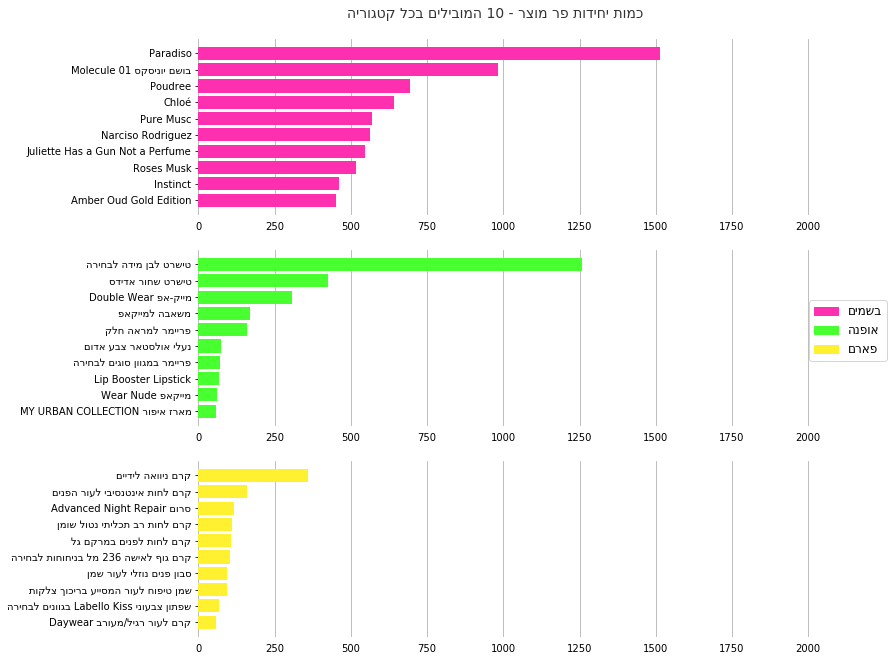

In [12]:
fig, axs = plt.subplots(ProductQuantity.index.unique(level=0).shape[0], figsize=(11,11))

pltnum = 0
xmax = ProductQuantity.max() + 500    # Setting max tick for x axis

for i in ProductQuantity.index.unique(level=0):
    # set bar colors based on category
    for k, v in SubCategoryColors.items():
        if i == k:
            pltcolor = v 
    axs[pltnum].barh(ProductQuantity.loc[i].head(10).index, ProductQuantity.loc[i].head(10), zorder=3, color=pltcolor)
    axs[pltnum].invert_yaxis()
    axs[pltnum].set_xlim(0, xmax)
    axs[pltnum].xaxis.grid(zorder=0)
    axs[pltnum].spines['right'].set_visible(False)
    axs[pltnum].spines['top'].set_visible(False)
    axs[pltnum].spines['left'].set_visible(False)
    axs[pltnum].spines['bottom'].set_visible(False)
    axs[pltnum].yaxis.set_ticks_position('left')
    axs[pltnum].xaxis.set_ticks_position('none')
    pltnum = pltnum + 1


# add title
fig.suptitle(bidialg.get_display(u'כמות יחידות פר מוצר - 10 המובילים בכל קטגוריה'), y=0.92, fontsize=14, color='#333333') 

# add legend
legend_handles = []
for k, v in SubCategoryColors.items():
        p = mpatches.Patch(color=v, label=k)
        legend_handles.append(p)
    
fig.legend(loc='center right', handles=legend_handles, fontsize=12)

# save plot to png file
fig.savefig('top_products_by_quantity_by_subCategory.png', transparent=True, dpi=600, bbox_inches='tight')
plt.show()

#### Plot leading products by quantity with color coding by category

In [13]:
# calculate average price per product
Product_AvgPrice = (df[(df.Quantity>0)].groupby(['Product']).sum().Amount/df[(df.Quantity>0)].groupby(['Product']).sum().Quantity).rename('Price')
# product_quantity_labels2 = []
# for product in product_quantity_labels:
#     for index, value in Product_AvgPrice.items():
#         if product == bidialg.get_display(index):
#             product_quantity_labels2.append('(₪ ' + str(round(value)) + ') ' + product)

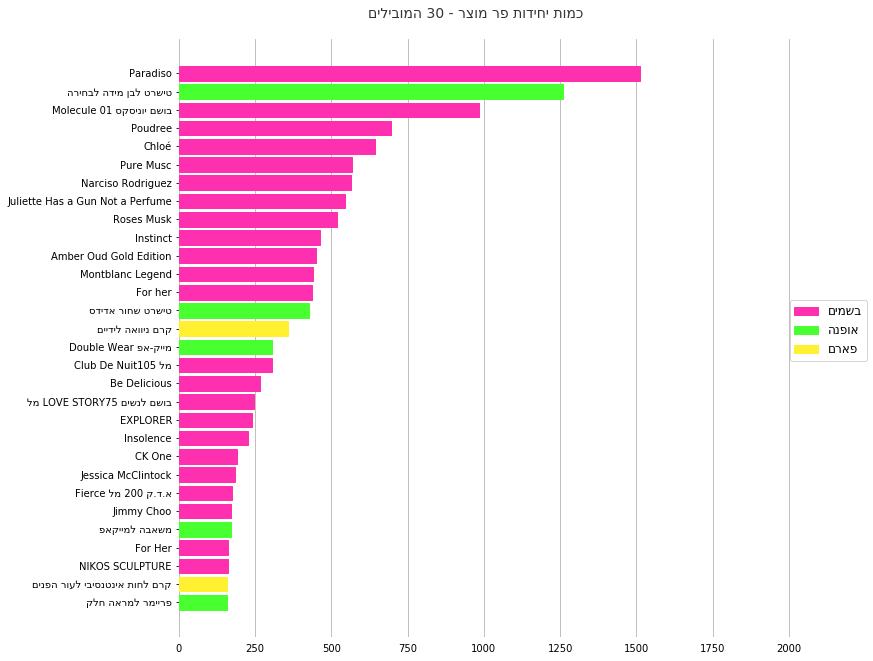

In [14]:
"""choose the number of product to display, default = 30"""
top = 30

fig, ax = plt.subplots(figsize=(11,11))
ax.barh(ProductQuantity.head(top).index.get_level_values(1), ProductQuantity.head(top), zorder=3)

# personalize axis and grids
ax.invert_yaxis()
ax.set_xlim(0, xmax)
ax.xaxis.grid(zorder=0, aa=1)

# remove spines and ticks
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('none')

        
# set bar colors based on category
for i in range(1,top+1,1):
    for (i0,i1), v in ProductQuantity.head(i).iteritems():
        for k, v in SubCategoryColors.items():
            if i0 == k:
                ax.get_children()[i-1].set_color(v)         


# add legend
legend_handles = []
for k, v in SubCategoryColors.items():
        p = mpatches.Patch(color=v, label=k)
        legend_handles.append(p)
fig.legend(loc='center right', handles=legend_handles, fontsize=12)


# add title
fig.suptitle(bidialg.get_display(u'כמות יחידות פר מוצר - {} המובילים'.format(top)), y=0.92, fontsize=14, color='#333333') 
#ax.set_title(bidialg.get_display(u'בסוגריים מחיר ממוצע של מוצר בתקופה'), fontsize=11, color='#333333') 


# save plot to png file
fig.savefig('top_products_by_quantity.png', transparent=True, dpi=600, bbox_inches='tight')

plt.show()